In [19]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from scipy.linalg import orth
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.decomposition import PCA
from terminaltables import AsciiTable as Table
import torch
from tqdm.notebook import tqdm

In [11]:
import sys
sys.path.append('../src/')

In [37]:
from utils import accumulate_grads_over_epochs, calc_projection

In [13]:
def estimate_optimal_ncomponents(mat):
    pca = PCA()
    pca.fit(mat)
    opt = []
    total_var = 0
    nc = 0
    for var in pca.explained_variance_ratio_:
        total_var += var
        nc += 1
        if total_var >= 0.99:
            opt.append(nc)
            break
        elif total_var >= 0.95:
            opt.append(nc)
    return opt[0], opt[-1], len(pca.explained_variance_ratio_)

def pca_transform(mat):
    _, n, _ = estimate_optimal_ncomponents(mat)
    pca = PCA(n_components=n)
    return pca.fit_transform(mat)

def cosine_sim(u, v):
    return 1-cosine(u, v)

In [16]:
data = ['mnist', 'fmnist']
lrs = [1e-2, 1e-3]
clfs = {
    'resnet18': [1024],
#     'fcn': [256, 1024],
}

files = {}
for d in data:
    for lr in lrs:
        for clf, batches in clfs.items():
            if clf == 'svm' and d=='cifar':
                lr *= 1e-3
            elif clf == 'svm':
                    lr *= 1e-2
            files[
                '../ckpts/{}_centralized/history/'
                'clf_{}_noise_None_paradigm_sgd_lr_{}_decay_'
                '1e-05_batch_{}_distributed_sim.pkl'.format(d, clf, lr, 1024)] = '{}/{}/{}'.format(d,clf,lr)

# Same Dataset Different Models

```python
grads->[
    epoch ->[
        minibatch->[
            layers->[
                tensors
            ]
        ]
    ]
]
```

In [ ]:
epochs = 11

nc_95 = defaultdict(list)
nc_90 = defaultdict(list)
f_hash = {}
for file, tick_name in tqdm(files.items(), leave=False):
    _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(111)
    tick_names = []
    ticks = []
    print('[file:{}]'.format(tick_name))
    table = [['expt', 'max(acc)', 'min(loss)', 'opt(0.95)', 'opt(0.99)']]
    for ep in tqdm(range(epochs), leave=False):
        ticks.append(ep)
        tick_names.append('{}/{}'.format(tick_name, ep))
        best_acc = np.max(acc_test)
        best_loss = np.min(loss_test)
        gradi = grads[ep]
        tot_opt_95 = 0
        tot_opt_99 = 0
        tot_epochs = 0
        for layer_num in range(len(gradi[0])):
            accum = []
            for b_num in range(len(gradi)):
                g = gradi[b_num][layer_num]
                shape = g.shape
                accum.append(g.reshape(1, -1).cpu().numpy())
            stack_g = np.vstack(accum)
            o_95, o_99, o_epochs = estimate_optimal_ncomponents(stack_g.T)
            tot_opt_95 += o_95
            tot_opt_99 += o_99
            tot_epochs += 1
        table.append([tick_name, 
                      '{:.4f}'.format(best_acc), 
                      '{:.4f}'.format(best_loss),
                      '{:.4f}'.format(tot_opt_95/tot_epochs), 
                      '{:.4f}'.format(tot_opt_99/tot_epochs)])
        nc_95[tick_name].append(tot_opt_99/tot_epochs)
        nc_90[tick_name].append(tot_opt_95/tot_epochs)
        
        idx = ep
        plt.bar(idx-0.25, acc_test[ep]*100, width = 0.2, color='b')
        plt.bar(idx-0.25, loss_test[ep], width=0.2, color='y')
        plt.bar(idx, len(gradi), width=0.2, color='g')
        plt.bar(idx+0.25, tot_opt_95/tot_epochs, width=0.2, color='r')
        plt.bar(idx+0.25, tot_opt_99/tot_epochs, width=0.2, color='r', alpha=0.5)
        idx += 1
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(tick_names, rotation='vertical')
    ax1.grid()
    plt.show()
    

mnist/resnet18/0.01


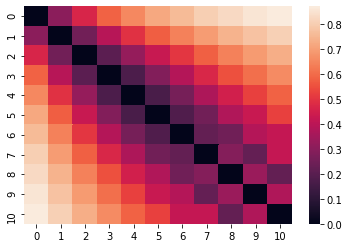

mnist/resnet18/0.001


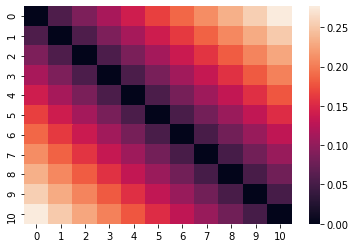

fmnist/resnet18/0.01


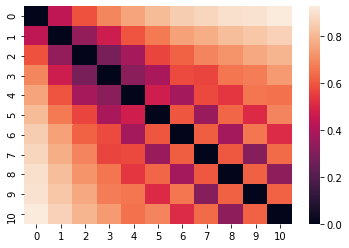

fmnist/resnet18/0.001


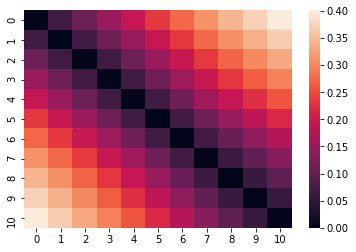

In [105]:
epochs = 11

nc_95 = defaultdict(list)
nc_90 = defaultdict(list)
f_hash = {}
for file, tick_name in tqdm(files.items(), leave=False):
    print(tick_name)
    _,_,acc_test,_, loss_test, grads = pkl.load(open(file, 'rb'))
    grads = accumulate_grads_over_epochs(grads, torch.device('cpu'))
    approx = []
    for i in range(len(grads)):
        ai = []
        for grad in grads:
            ai.append(gradient_approximation(grad,[grads[i]], torch.device('cpu')))
        approx.append(np.array(ai).reshape(-1, 1))
    sns.heatmap(np.hstack(approx))
    plt.show()

In [21]:
len(grads)

11

In [101]:
def gradient_approximation(true_grads, sdirs, device):
    approx_grads = []
    idx = 0
    for idx, g in enumerate(true_grads):
        true_grads[idx] = g.flatten()
        approx_grads.append(torch.zeros(g.flatten().size()))
        idx += 1
    for sdir in sdirs:
        for idx, (p, s, g) in enumerate(zip(approx_grads, sdir, true_grads)):
            size = p.size()
            grad_flat = p.flatten()
            true_grad = g.clone()
            grad_flat = grad_flat + \
                calc_projection(true_grad, s.flatten()) * s.flatten()
#             true_grads[idx] = true_grad - grad_flat
#             print(torch.norm(true_grad))
            approx_grads[idx] = grad_flat
    error_norm = 0
    num_layers = 0
    for p, g in zip(approx_grads, true_grads):
        error_norm += torch.norm(g-p.flatten()
                                 ).item()/torch.norm(g).item()
        num_layers += 1
#     print(error_norm, error_norm/num_layers)

    return error_norm/num_layers

In [103]:
num_dirs = 0
decom_dir = [[_.clone() for _ in grads[0]]]
for i in range(num_dirs):
    dir_i = []
    for layer in grads[0]:
        dir_i.append(layer + torch.normal(mean=0.0, std=1.0/num_dirs, size=layer.size()))
    decom_dir.append(dir_i)

In [104]:
for grad in grads:
    print(gradient_approximation(grad, decom_dir, torch.device('cpu')))

ZeroDivisionError: float division by zero

In [79]:
approx = []
for i in range(len(grads)):
    ai = []
    for grad in grads:
        ai.append(gradient_approximation(grad,[grads[i]], torch.device('cpu')))
    approx.append(np.array(ai).reshape(-1, 1))

In [80]:
approx[0].shape

(11, 1)

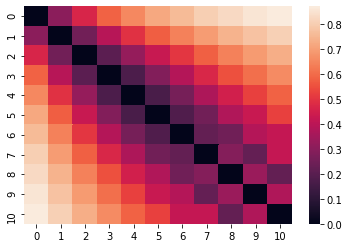

In [84]:
sns.heatmap(np.hstack(approx))